## Intro Time Series 

**Data Source:** [Weather history download Basel](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604)

**date:** 2020-05-14

In this notebook we want to show how to manipulate and plot time series data in python. 

## Prepare Notebook

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data 

In [2]:
raw_df = pd.read_csv('../../../data/basel_weather.csv')

raw_df.head()

,timestamp,Basel Temperature [2 m elevation corrected],Basel Precipitation Total,Basel Wind Speed [10 m],Basel Wind Direction [10 m]
0,20080101T0200,-0.109471,0.0,0.000000,180.00000
1,20080101T0300,1.900529,0.0,2.397600,89.99999
2,20080101T0400,1.610529,0.0,0.799200,180.00000
3,20080101T0500,1.110529,0.0,0.842431,198.43495
4,20080101T0600,0.820529,0.0,2.527292,161.56505


## Format Data 

We add some additional features. 

In [3]:
data_df = raw_df.copy()

data_df = data_df.rename(columns={
    'Basel Temperature [2 m elevation corrected]': 'temperature', 
    'Basel Precipitation Total': 'precipitation', 
    'Basel Wind Speed [10 m]': 'wind_speed', 
    'Basel Wind Direction [10 m]': 'wind_direction'
    }
)

data_df = data_df.assign(
    timestamp = lambda x: pd.to_datetime(x['timestamp']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)

data_df.head()

,timestamp,temperature,precipitation,wind_speed,wind_direction,date,year,month,day,dayofyear,hour
0,2008-01-01 02:00:00,-0.109471,0.0,0.000000,180.00000,2008-01-01,2008,1,1,1,2
1,2008-01-01 03:00:00,1.900529,0.0,2.397600,89.99999,2008-01-01,2008,1,1,1,3
2,2008-01-01 04:00:00,1.610529,0.0,0.799200,180.00000,2008-01-01,2008,1,1,1,4
3,2008-01-01 05:00:00,1.110529,0.0,0.842431,198.43495,2008-01-01,2008,1,1,1,5
4,2008-01-01 06:00:00,0.820529,0.0,2.527292,161.56505,2008-01-01,2008,1,1,1,6


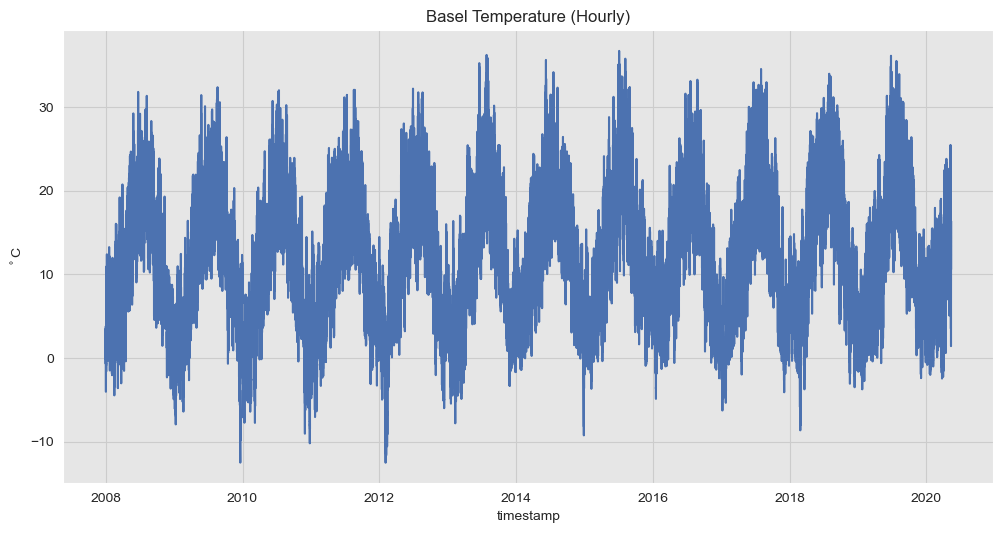

In [4]:
# Let us plot the temperature hourly development over time. 
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='temperature', data=data_df, ax=ax)
ax.set(title='Basel Temperature (Hourly)', ylabel=r'$^\circ$C')
plt.savefig(f'../images/basel_hourly_ts.png', dpi=200, bbox_inches='tight');

In [5]:
# Next, we aggregate by day. 
daily_data_df = data_df \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'temperature': np.mean}) \
    .set_index('date')

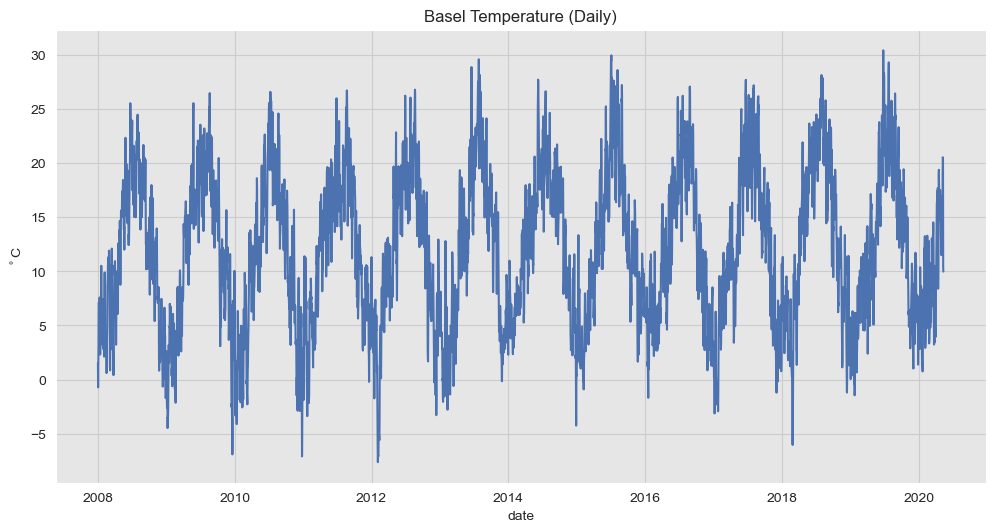

In [6]:
# Plot daily data. 
fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Basel Temperature (Daily)', ylabel=r'$^\circ$C')
plt.savefig(f'../images/basel_daily_ts.png', dpi=200, bbox_inches='tight');

Here is a way to plot the yearly seasonality of temperature:

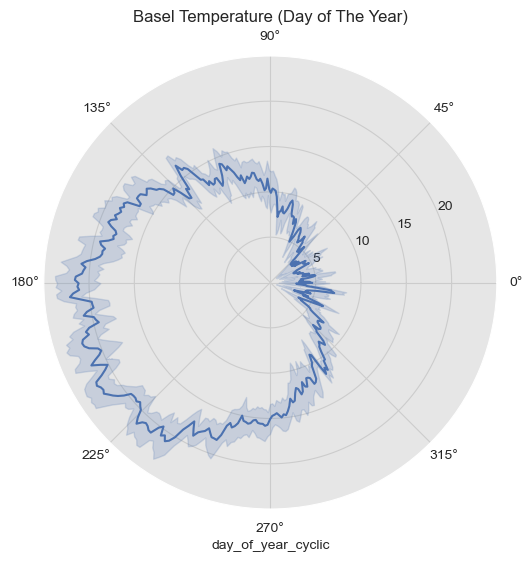

In [7]:
ax = plt.subplot(111, projection='polar')

daily_data_df \
    .assign(day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.5)) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='temperature', 
        ax=ax
    )

ax.set_ylabel('')
ax.set_title('Basel Temperature (Day of The Year)', va='bottom')
plt.savefig(f'../images/basel_daily_cyclic.png', dpi=200, bbox_inches='tight');

## Smoothing

- Moving Average 

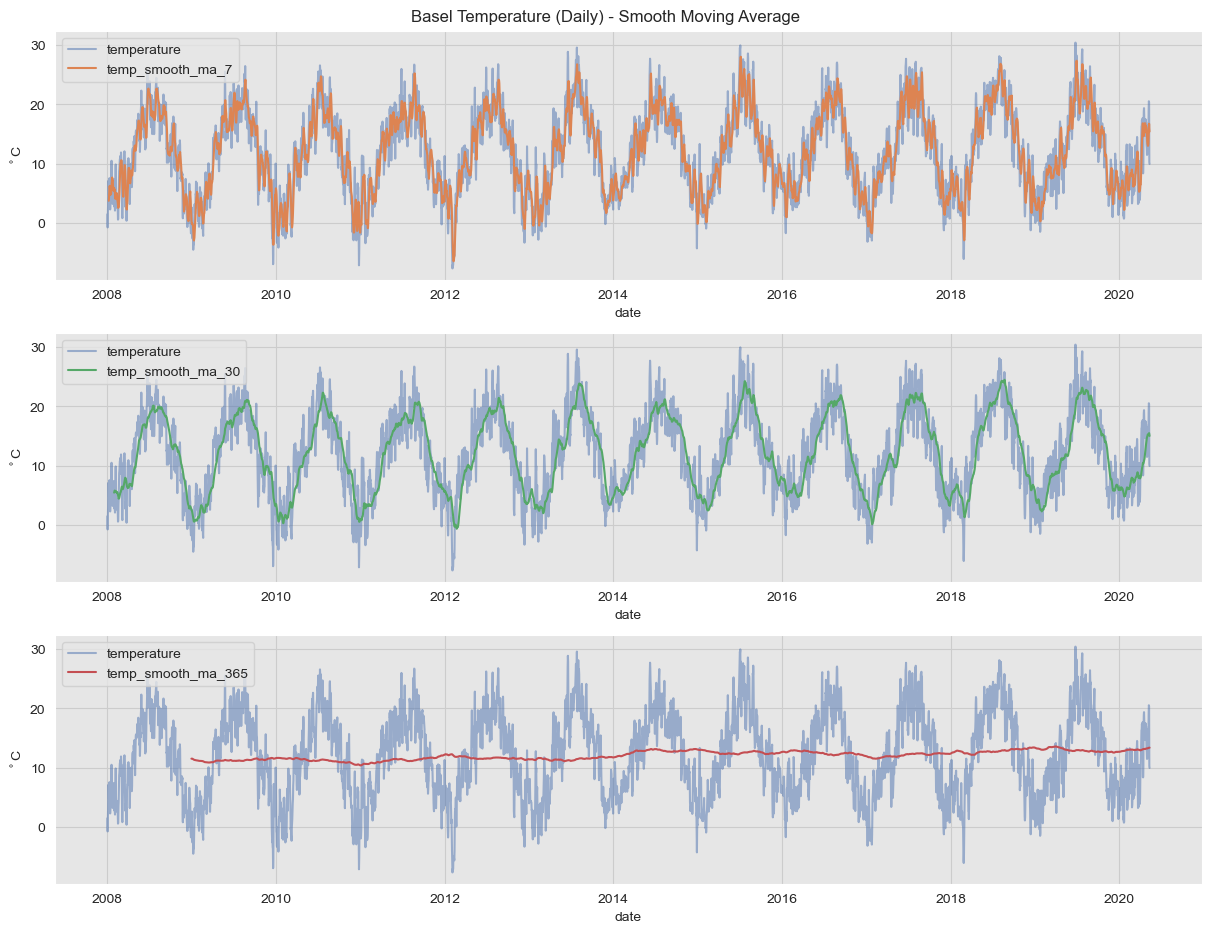

In [8]:
ma =[7, 30, 365]

smooth_daily_data_df = daily_data_df \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot.
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'temp_smooth_ma_{m}'] = smooth_daily_data_df['temperature'].rolling(window=m).mean()

    sns.lineplot(x='date', y='temperature', label='temperature', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'temp_smooth_ma_{m}', label=f'temp_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel=r'$^\circ$C');

plt.suptitle('Basel Temperature (Daily) - Smooth Moving Average', y=1.02)
plt.savefig(f'../images/basel_daily_ma.png', dpi=200, bbox_inches='tight');

- Gaussian Filter

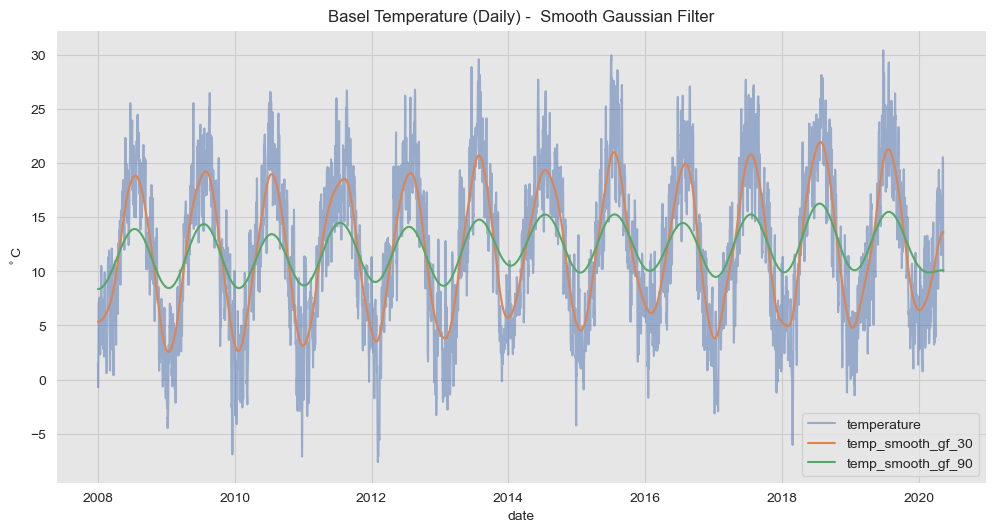

In [9]:
from scipy.ndimage import gaussian_filter

smooth_daily_data_df = smooth_daily_data_df \
    .assign(temp_smooth_gf_30 = lambda x: gaussian_filter(input=x['temperature'], sigma=30)) \
     .assign(temp_smooth_gf_90 = lambda x: gaussian_filter(input=x['temperature'], sigma=90))

fig, ax = plt.subplots()
sns.lineplot(x='date', y='temperature', label='temperature', data=smooth_daily_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='temp_smooth_gf_30', label='temp_smooth_gf_30', data=smooth_daily_data_df, color=sns_c[1], ax=ax)
sns.lineplot(x='date', y='temp_smooth_gf_90', label='temp_smooth_gf_90', data=smooth_daily_data_df, color=sns_c[2], ax=ax)
ax.legend(loc='lower right')
ax.set(title='Basel Temperature (Daily) -  Smooth Gaussian Filter', ylabel=r'$^\circ$C')
plt.savefig(f'../images/basel_daily_gf.png', dpi=200, bbox_inches='tight');

## Time Series Decomposition

We can use the method `seasonal_decompose` from `statsmodels.tsa.seasonal` to decompose the daily data. This method is based on moving averages.  

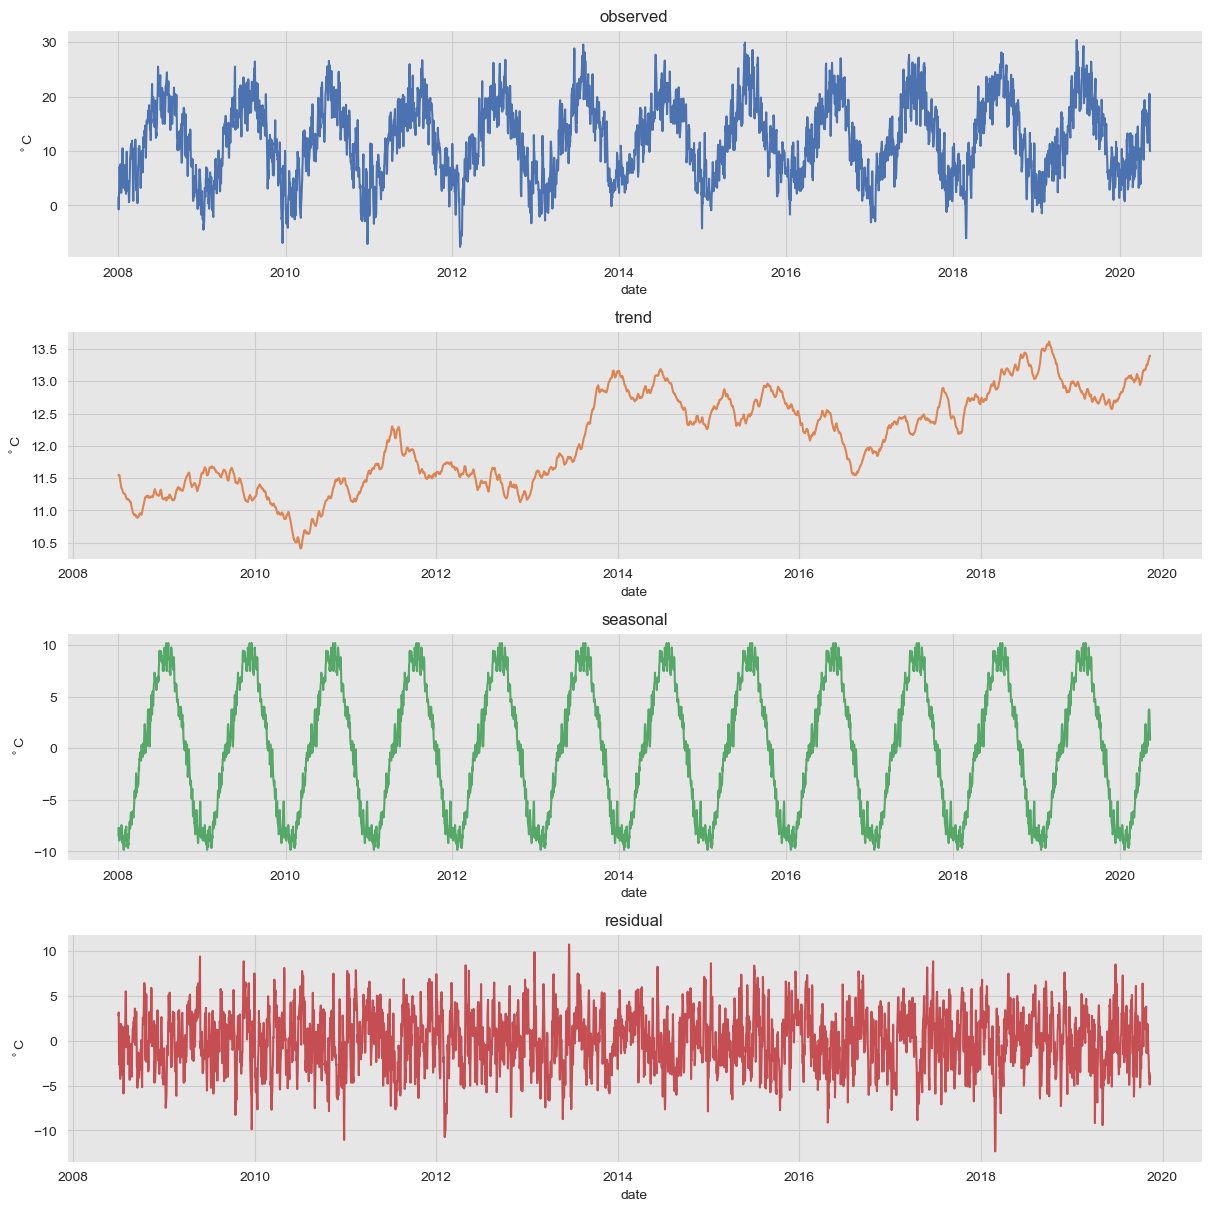

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['temperature'], 
    model='additive', 
    period=365
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel=r'$^\circ$C')
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'$^\circ$C')
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'$^\circ$C')
plt.savefig(f'../images/basel_daily_decomp0.png', dpi=200, bbox_inches='tight');

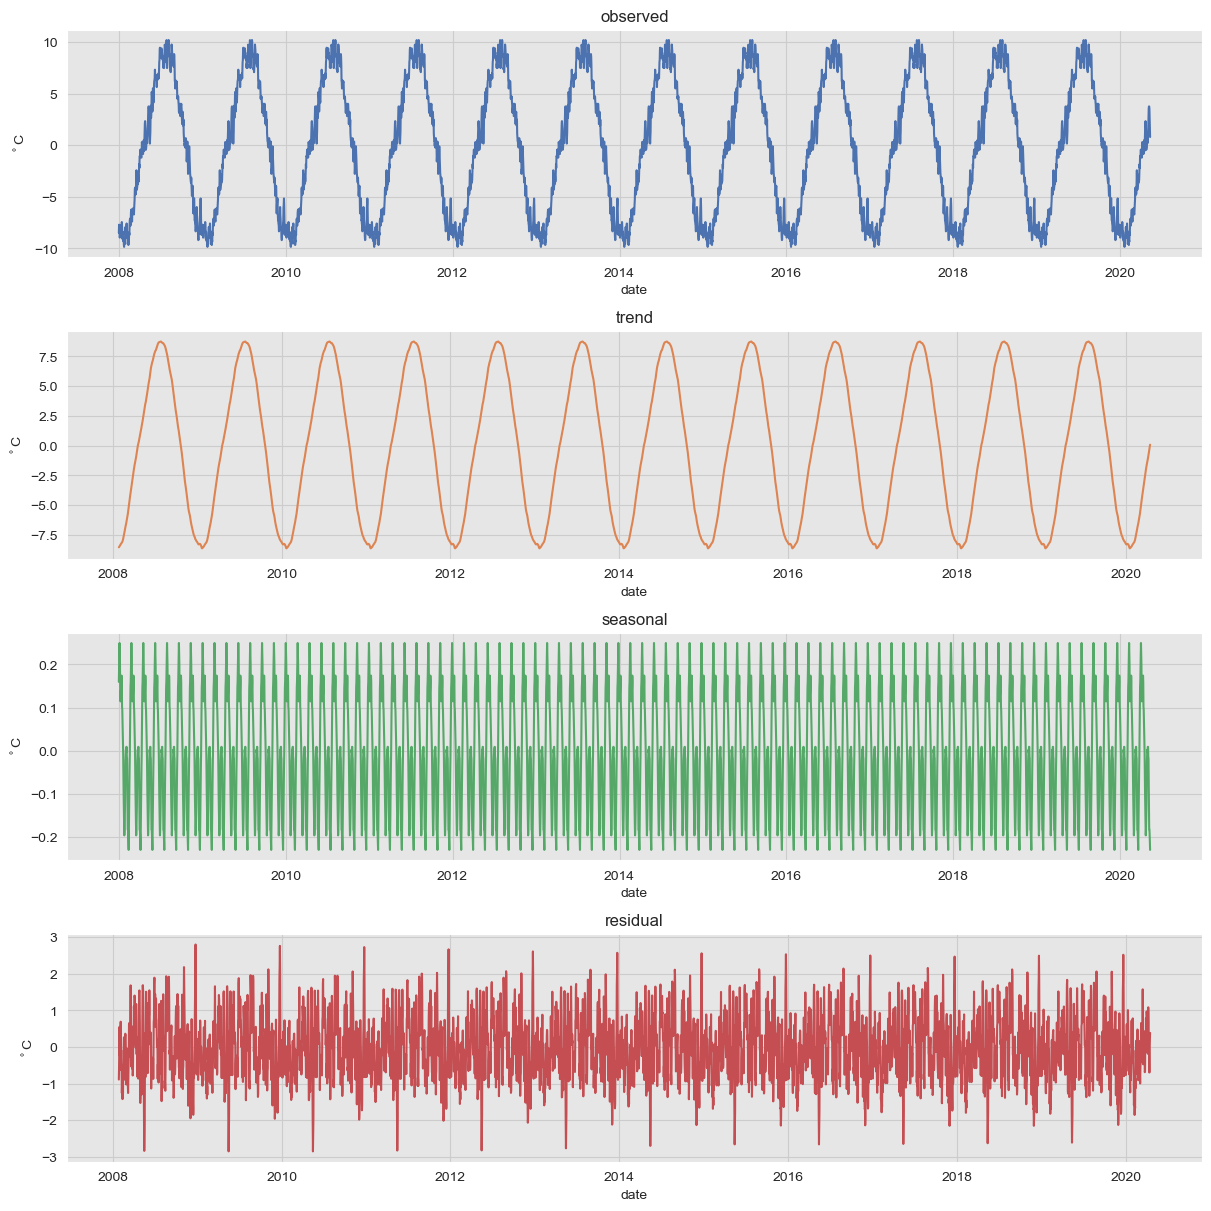

In [11]:
# We can now decompose the seasonal component from above. 
seas_decomp_monthly = seasonal_decompose(
    x=seas_decomp_yearly.seasonal, 
    model='additive', 
    period=52
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_monthly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel=r'$^\circ$C')
seas_decomp_monthly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'$^\circ$C')
seas_decomp_monthly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
seas_decomp_monthly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'$^\circ$C')
plt.savefig(f'../images/basel_daily_decomp1.png', dpi=200, bbox_inches='tight');

- Intuition Behind Time Series Decomposition

The main idea is to model each component separately. Let us see how to do it using [Fourier modes](https://en.wikipedia.org/wiki/Fourier_series).

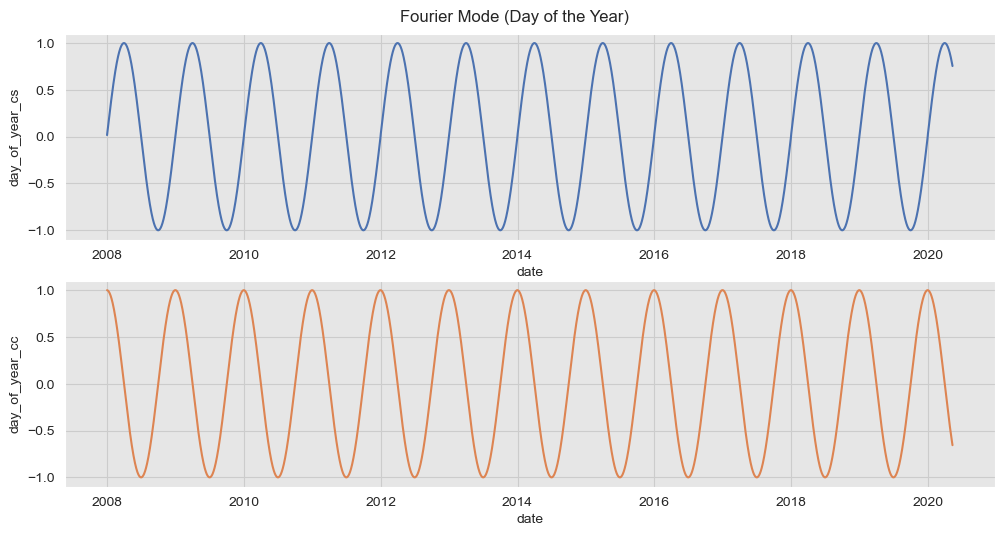

In [12]:
import statsmodels.formula.api as smf

# Create linear trend and cyclical variables to model the day of the year. 
smooth_daily_data_df = smooth_daily_data_df.assign(
    index = lambda x: np.linspace(start=0, stop=x.shape[0]-1, num=x.shape[0]),
    day_of_year_cs = lambda x: np.sin(2*np.pi*x['dayofyear']/365.5),
    day_of_year_cc = lambda x: np.cos(2*np.pi*x['dayofyear']/365.5)
)

fig, ax = plt.subplots(2, 1)
sns.lineplot(x='date', y='day_of_year_cs', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
sns.lineplot(x='date', y='day_of_year_cc', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
plt.suptitle('Fourier Mode (Day of the Year)', y=0.92);
plt.savefig(f'../images/day_of_year_fourier.png', dpi=200, bbox_inches='tight');

Next, we use a linear model to fit each component:

In [13]:
decomp_model = smf.ols(formula = 'temperature ~ index + day_of_year_cs + day_of_year_cc', data=smooth_daily_data_df)

decomp_red = decomp_model.fit()

print(decomp_red.summary())

OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     5011.
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        19:33:01   Log-Likelihood:                -11927.
No. Observations:                4516   AIC:                         2.386e+04
Df Residuals:                    4512   BIC:                         2.389e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.0855      0.101    109.655      0.000      10.887  

Finally, let us extract each component.

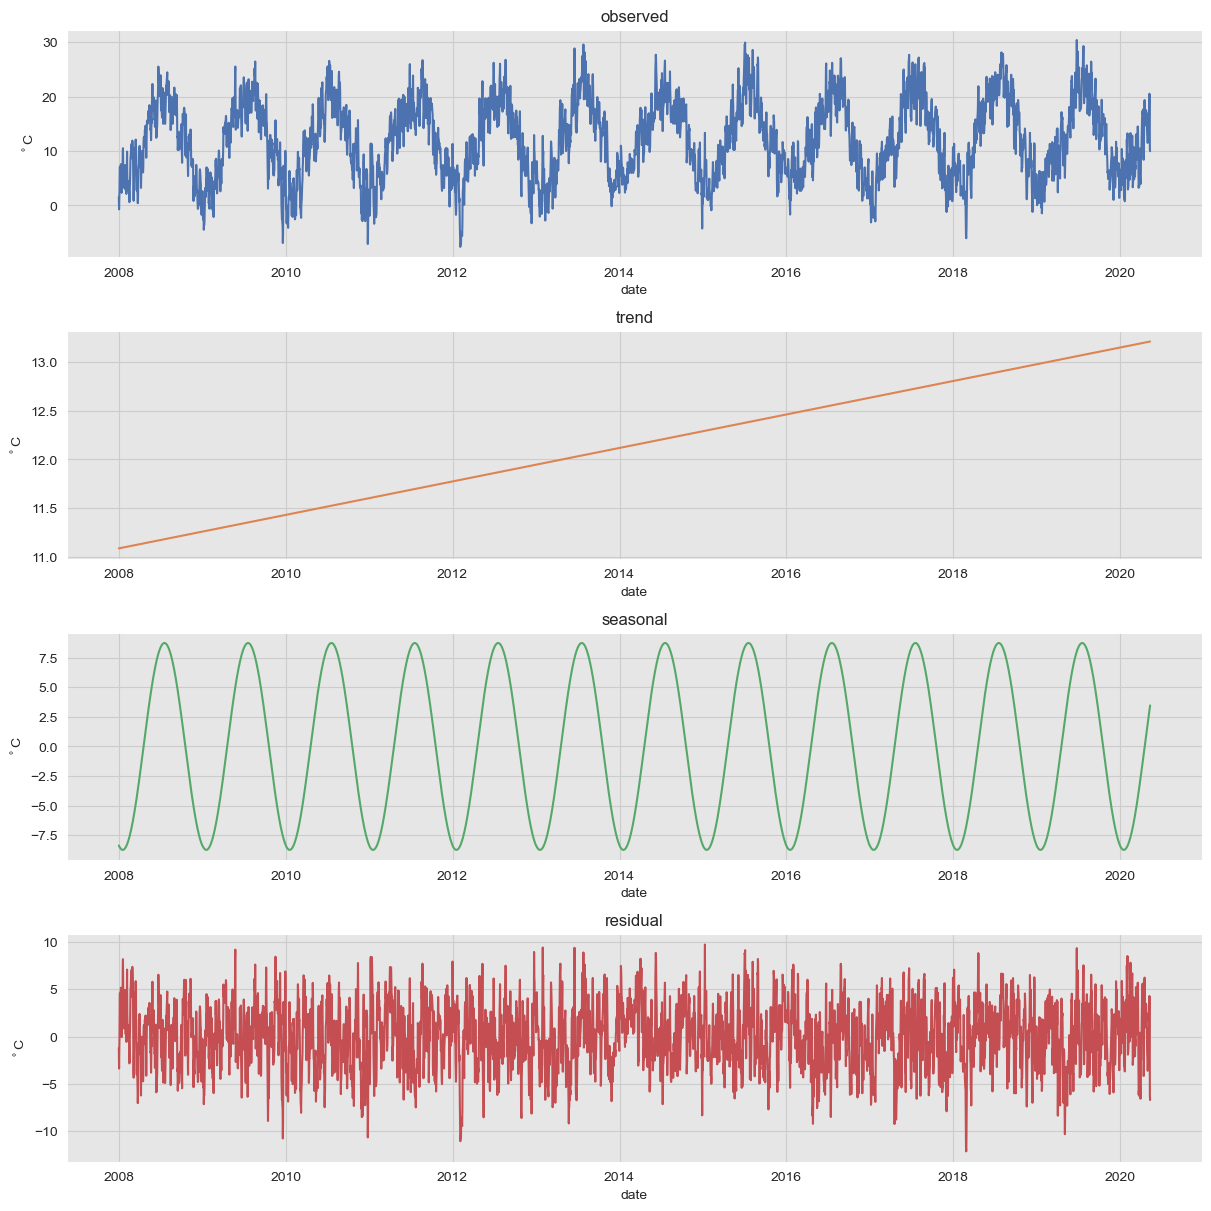

In [14]:
smooth_daily_data_df = smooth_daily_data_df.assign(
    decomp_trend = decomp_red.predict(smooth_daily_data_df.assign(day_of_year_cs = 0.0, day_of_year_cc = 0.0)),
    decomp_seas = decomp_red.predict(smooth_daily_data_df.assign(index = 0.0)) - decomp_red.params['Intercept'],
    decomp_error = lambda x: x['temperature'] - x['decomp_trend'] - x['decomp_seas']
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sns.lineplot(x='date', y='temperature', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel=r'$^\circ$C')

sns.lineplot(x='date', y='decomp_trend', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel=r'$^\circ$C')

sns.lineplot(x='date', y='decomp_seas', data=smooth_daily_data_df, color=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel=r'$^\circ$C')

sns.lineplot(x='date', y='decomp_error', data=smooth_daily_data_df, color=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel=r'$^\circ$C');

plt.savefig(f'../images/basel_daily_decomp_fourier.png', dpi=200, bbox_inches='tight');

The results are similar as above.